# Quantum Teleportation

In [1]:
%pip install qiskit matplotlib azure-quantum[qiskit]

Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit import *


$\providecommand{\ket}[1]{\left|#1\right\rangle}$
$\providecommand{\bra}[1]{\left\langle#1\right|}$

In this sample we will be looking at using quantum teleportation on Azure Quantum.

To refresh our mind let us review how quantum teleportation works.

We have two parties, Alice and Bob, they would like to share information, and they have an entangled state (usually the Bell state $\frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$). 
If Alice now wishes to transfer quantum information, she will entangle some payload with her qubit and measure her qubit and payload.She will transmit the results of the measurement to Bob, who can use them to reconstruct Alice's payload on his entangled qubit.

In the following code we will implement this operation.

In [3]:
def create_bell_state():
    (alice, bob) = (QuantumRegister(1), QuantumRegister(1))
    qc = QuantumCircuit(alice, bob)
    qc.name = 'create_bell_state'
    qc.h(alice)
    qc.cx(alice, bob)
    return qc.to_instruction()


def send():
    (alice, payload) = (QuantumRegister(1), QuantumRegister(1))
    (cr_x, cr_z) = (ClassicalRegister(1), ClassicalRegister(1))
    qc = QuantumCircuit(alice, payload, cr_x, cr_z)
    qc.name = 'send'
    qc.cx(payload, alice)
    qc.h(payload)
    qc.measure(alice, cr_x)
    qc.measure(payload, cr_z)
    return qc.to_instruction()


def recv(qc: QuantumCircuit, bob: QuantumRegister, cr_x: ClassicalRegister, cr_z: ClassicalRegister):
    qc.x(bob).c_if(cr_x, 1);
    qc.z(bob).c_if(cr_z, 1);

We will now use Qiskit's visualization tools to look show the Unitary responsible from creating the Bell State.
Showing operations is a great way to check whether your implementation is mathematically correct.

In [4]:
def create_teleport_circuit_base():
    (alice, bob, payload) = (QuantumRegister(1, 'alice'), QuantumRegister(1,'bob'), QuantumRegister(1,'payload'))
    (cr_x, cr_z, res) = (ClassicalRegister(1, 'cr_x'), ClassicalRegister(1, 'cr_z'), ClassicalRegister(1, 'res'))
    return (QuantumCircuit(alice, bob, payload, cr_x, cr_z, res), alice, bob, payload, cr_x, cr_z, res)

In [5]:
from qiskit import Aer

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
qc = QuantumCircuit(alice, bob)
qc.append(create_bell_state(), [alice, bob])

backend = Aer.get_backend('unitary_simulator')

job = execute(qc, backend)
result = job.result()

print(result.get_unitary(qc, decimals=3).data)


[[ 0.707+0.j  0.707-0.j  0.   +0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j -0.707+0.j]
 [ 0.   +0.j  0.   +0.j  0.707+0.j  0.707-0.j]
 [ 0.707+0.j -0.707+0.j  0.   +0.j  0.   +0.j]]


Below we will now verify that our teleportation does indeed work correctly.

We will be visualizing our circuit using Qiskit's tools to manually introspect it for correctness.

In [6]:
def perform_teleportation_on_bell_state(qc : QuantumCircuit, 
                                        alice: QuantumRegister, bob: QuantumRegister, payload: QuantumRegister, 
                                        cr_x: ClassicalRegister, cr_z: ClassicalRegister):
    qc.append(send(), [alice, payload], [cr_x, cr_z])
    recv(qc, bob, cr_x, cr_z)
    return qc

def create_full_teleport_circuit():
    (qc, alice, bob, payload, cr_x, cr_z, _) = create_teleport_circuit_base()

    qc.append(create_bell_state(), [alice, bob])
    qc.barrier()
    perform_teleportation_on_bell_state(qc, alice, bob, payload, cr_x, cr_z)
    return qc


create_full_teleport_circuit().draw(fold=-1)

C:\Users\t-alehmann\AppData\Roaming\Python\Python39\site-packages\qiskit\visualization\text.py:717: RuntimeWarning: The parameter "cregbundle" was disabled, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


┌────────────────────┐ ░ ┌───────┐          
  alice: ┤0                   ├─░─┤0      ├──────────
         │  create_bell_state │ ░ │       │┌───┐┌───┐
    bob: ┤1                   ├─░─┤       ├┤ X ├┤ Z ├
         └────────────────────┘ ░ │       │└─╥─┘└─╥─┘
payload: ───────────────────────░─┤1 send ├──╫────╫──
                                ░ │       │  ║    ║  
   cr_x: ═════════════════════════╡0      ╞══■════╬══
                                  │       │ 0x1   ║  
   cr_z: ═════════════════════════╡1      ╞═══════■══
                                  └───────┘      0x1 
    res: ════════════════════════════════════════════

We will now simulate our code and see that we manage to teleport our payload correctly.
For this Alice rotates the payload at an unusual angle and make sure that the adjoint rotation resets Bob's qubit to $\ket{0}$ making the overall state of the system $\ket{000}$.

In [7]:
from qiskit.tools.visualization import plot_histogram

(qc_prep, alice, bob, payload, cr_x, cr_z, res) = create_teleport_circuit_base()
qc_prep.ry(0.2791, payload)

(qc_meas, alice, bob, payload, cr_x, cr_z, res) = create_teleport_circuit_base()
qc_meas.ry(-0.2791, bob)
qc_meas.measure(bob, res)
# Reset cr_x cr_z qubits to clean up ouput
qc_meas.reset(payload)
qc_meas.measure(payload, cr_x)
qc_meas.measure(payload, cr_z)

qc = qc_prep + create_full_teleport_circuit() + qc_meas

simulator = Aer.get_backend('aer_simulator')

qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=500).result()
counts = result.get_counts(qc_t)
plot_histogram(counts, title="Bob's qubit state")

Seeing empirically that our teleportation works, we can proceed to run it on hardware and measure the fidelity.


As a first step we need to set up our Azure Quantum provider and see the backends it offers.

In [12]:
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

['ionq.qpu', 'ionq.simulator', 'quantinuum.hqs-lt-s1', 'quantinuum.hqs-lt-s1-apival', 'quantinuum.hqs-lt-s2', 'quantinuum.hqs-lt-s2-apival', 'quantinuum.hqs-lt-s1-sim', 'quantinuum.hqs-lt-s2-sim']


In [ ]:
provider = AzureQuantumProvider(
  resource_id="",
  location=""
)

In [ ]:
print([backend.name() for backend in provider.backends()])

When running jobs on Azure Quantum, before going to real hardware it is recommended to run your code through a validator to make sure you don't waste precious resources on faulty code. `quantinuum.hqs-lt-s2-apival` is the appropriate target for this.


We now transpile our code for the target and run it for validation. For this we create a job, submit it, then monitor it using `job_monitor` (a function that blocks execution until execution of the job is complete) and proceed to introspect the results

In [13]:
validator_backend = provider.get_backend("quantinuum.hqs-lt-s2-apival")
qc_t = transpile(qc, validator_backend)
job = validator_backend.run(qc_t, job_name="Validate Entanglement Swapping")
job_id = job.id()
print("Job id", job_id)


Job id ea87415f-256d-11ed-92be-dc215ca5fadb


In [14]:
job_monitor(job)


Job Status: job has successfully run


In [20]:
result = job.result()
if not result.success:
    raise Exception("API validation Failed")
print("API validation succeeded!")


API Validation succeeded!


Now with the confidence that our job will work we can submit it to the simulator.  The Quantinuum emulator provided by Azure Quantum differs from the simulator running locally, in that it accurately models noise and behavior of the Quantinuum quantum computer.

In [ ]:
sim_backend = provider.get_backend("quantinuum.hqs-lt-s2-sim")
qc_t = transpile(qc, validator_backend, job_name="Simulate Entanglement Swapping")
job = sim_backend.run(qc_t)
job_id = job.id()
print("Job id", job_id)

In [ ]:
job_monitor(job)


In [ ]:
result = job.result()
print(result)


In [ ]:
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(qc_t))
print(counts)
plot_histogram(counts)

We see that while quite good, we do get some noise from running our code on the emulator that accurately mimics a quantum device. With larger circuits such as the ones below this problem will only get worse.

Let us now enhance our code by building entanglement swapping. The idea of entanglement swapping is that if Alice and Bob do not have a direct connection but connections to third parties such that a path exists, then each pair of adjacent parties can create Bell states and teleport Alice's second qubit along this path until it reaches Bob.

First we build the base case of entanglement swapping `entanglement_swap_3`, then we proceed to build the general case `entanglement_swap_n`

In [21]:
def entanglement_swap_3(): 
    qc = QuantumCircuit(QuantumRegister(4, 'qc'), ClassicalRegister(2))
    qc.append(create_bell_state(), [0, 1])
    qc.append(create_bell_state(), [2, 3])
    qc.barrier()
    perform_teleportation_on_bell_state(qc, 2, 3, 1, 0, 1)
    qc.barrier()
    # Measure bell state in classical registers
    qc.measure(0, 0)
    qc.measure(3, 1)
    return qc


entanglement_swap_3().draw(fold=-1)

C:\Users\t-alehmann\AppData\Roaming\Python\Python39\site-packages\qiskit\visualization\text.py:717: RuntimeWarning: The parameter "cregbundle" was disabled, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


┌────────────────────┐ ░                     ░ ┌─┐   
qc_0: ┤0                   ├─░─────────────────────░─┤M├───
      │  create_bell_state │ ░ ┌───────┐           ░ └╥┘   
qc_1: ┤1                   ├─░─┤1      ├───────────░──╫────
      ├────────────────────┤ ░ │       │           ░  ║    
qc_2: ┤0                   ├─░─┤0      ├───────────░──╫────
      │  create_bell_state │ ░ │       │┌───┐┌───┐ ░  ║ ┌─┐
qc_3: ┤1                   ├─░─┤  send ├┤ X ├┤ Z ├─░──╫─┤M├
      └────────────────────┘ ░ │       │└─╥─┘└─╥─┘ ░  ║ └╥┘
c8_0: ═════════════════════════╡0      ╞══■════╬══════╩══╬═
                               │       │       ║         ║ 
c8_1: ═════════════════════════╡1      ╞═══════■═════════╩═
                               └───────┘

We will now simulate our entanglement swapping and see that our output is evenly (up to statistical error due to limited shots) split between $\ket{00}$ and $\ket{11}$, showing us that in the end Alice and Bob have a bell state shared between them.

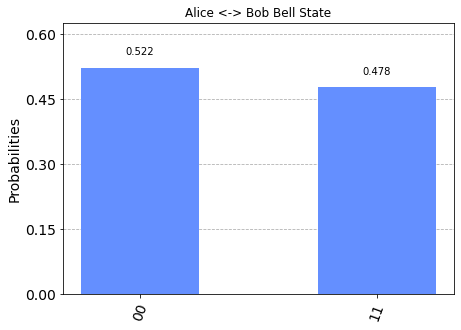

In [22]:
qc = entanglement_swap_3()

simulator = Aer.get_backend('aer_simulator')

qc = transpile(qc, simulator)
result = simulator.run(qc, shots=500).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Alice <-> Bob Bell State')

Let us now generalize this and build an entanglement swapping circuit for any number for qubits.

In [23]:
def entanglement_swap_n(nParties: int): 
    cr_x = ClassicalRegister(1, 'cr1')
    cr_z = ClassicalRegister(1, 'cr2')
    qc = QuantumCircuit(QuantumRegister(2 * nParties, 'qc'), cr_x, cr_z)
    for i in range(nParties):
        qc.append(create_bell_state(), [2 * i, 2 * i + 1])
    qc.barrier()
    for i in range(1, nParties):
        perform_teleportation_on_bell_state(qc, 2 * i, 2 * i + 1, 2 * i - 1, cr_x, cr_z)
        qc.barrier()
    # Measure bell state in classical registers
    qc.measure(0, cr_x)
    qc.measure(2 * nParties - 1, cr_z)
    return qc

entanglement_swap_n(4).draw(fold=-1)

┌────────────────────┐ ░                     ░                     ░                     ░ ┌─┐   
qc_0: ┤0                   ├─░─────────────────────░─────────────────────░─────────────────────░─┤M├───
      │  create_bell_state │ ░ ┌───────┐           ░                     ░                     ░ └╥┘   
qc_1: ┤1                   ├─░─┤1      ├───────────░─────────────────────░─────────────────────░──╫────
      ├────────────────────┤ ░ │       │           ░                     ░                     ░  ║    
qc_2: ┤0                   ├─░─┤0      ├───────────░─────────────────────░─────────────────────░──╫────
      │  create_bell_state │ ░ │       │┌───┐┌───┐ ░ ┌───────┐           ░                     ░  ║    
qc_3: ┤1                   ├─░─┤       ├┤ X ├┤ Z ├─░─┤1      ├───────────░─────────────────────░──╫────
      ├────────────────────┤ ░ │       │└─╥─┘└─╥─┘ ░ │       │           ░                     ░  ║    
qc_4: ┤0                   ├─░─┤       ├──╫────╫───░─┤0      ├───────────░─────────────────────░──╫────
      │  create_bell_state │ ░ │       │  ║    ║   ░ │       │┌───┐┌───┐ ░ ┌───────┐           ░  ║    
qc_5: ┤1                   ├─░─┤  send ├──╫────╫───░─┤       ├┤ X ├┤ Z ├─░─┤1      ├───────────░──╫────
      ├────────────────────┤ ░ │       │  ║    ║   ░ │       │└─╥─┘└─╥─┘ ░ │       │           ░  ║    
qc_6: ┤0                   ├─░─┤       ├──╫────╫───░─┤  send ├──╫────╫───░─┤0      ├───────────░──╫────
      │  create_bell_state │ ░ │       │  ║    ║   ░ │       │  ║    ║   ░ │       │┌───┐┌───┐ ░  ║ ┌─┐
qc_7: ┤1                   ├─░─┤       ├──╫────╫───░─┤       ├──╫────╫───░─┤  send ├┤ X ├┤ Z ├─░──╫─┤M├
      └────────────────────┘ ░ │       │  ║    ║   ░ │       │  ║    ║   ░ │       │└─╥─┘└─╥─┘ ░  ║ └╥┘
 cr1: ═════════════════════════╡0      ╞══■════╬═════╡0      ╞══■════╬═════╡0      ╞══■════╬══════╩══╬═
                               │       │ 0x1   ║     │       │ 0x1   ║     │       │ 0x1   ║         ║ 
 cr2: ═════════════════════════╡1      ╞═══════■═════╡1      ╞═══════■═════╡1      ╞═══════■═════════╩═
                               └───────┘      0x1    └───────┘      0x1    └───────┘      0x1

We shall now test to see how fidelity changes with number of qubits. As our circuit includes mid-circuit measurements we will be running on Quantinuum hardware (/simulators) as they are the only current provider allowing such operations.

We will first ensure correctness by running on a simulator and seeing the fidelity being 100%

Then we will use Azure Quantum to run on Quantinuum targets

In [25]:
import matplotlib.pyplot as plt

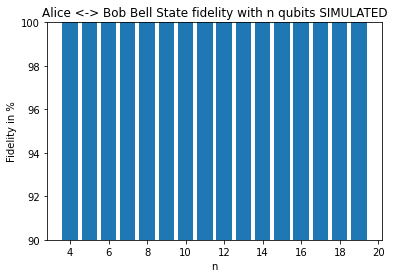

In [26]:
all_results = dict()

def get_fidelity(counts):
    total = sum(counts.values())
    return (counts['1 1'] + counts ['0 0']) / total * 100

for i in range(4,20):
    qc = entanglement_swap_n(i) 

    simulator = Aer.get_backend('aer_simulator')

    qc_t = transpile(qc, simulator)
    result = simulator.run(qc_t, shots=500).result()
    counts = result.get_counts(qc_t)
    all_results[i] = get_fidelity(counts)

plt.bar(all_results.keys(), all_results.values())
plt.title("Alice <-> Bob Bell State fidelity with n qubits SIMULATED")
plt.xlabel('n')
plt.ylabel('Fidelity in %')
plt.ylim([90,100])
plt.show()

Let us now validate our circuits again

In [27]:
for i in range(2,8):
    print(f"{i} parties uses {entanglement_swap_n(i).num_qubits} qubits")

2 parties uses 4 qubits
3 parties uses 6 qubits
4 parties uses 8 qubits
5 parties uses 10 qubits
6 parties uses 12 qubits
7 parties uses 14 qubits


Since the quantinuum H1-2 has 12 qubits, we will limit our number of parties to $\leq 6$

In [29]:
for i in range(2, 7):
    job_name = f"Validating entanglement swap with {i} parties"
    print(job_name)
    qc = entanglement_swap_n(i) 
    validator_backend = provider.get_backend("quantinuum.hqs-lt-s2-apival")
    qc_t = transpile(qc, validator_backend)
    job = validator_backend.run(qc_t, job_name=job_name)
    job_id = job.id()
    job_monitor(job)
    result = job.result()
    if not result.success:
        raise Exception(f"API validation failed for {i} parties")
    print(f"API validation succeeded for {i} parties!")

Validating entanglement swap with 2 parties
Job Status: job has successfully run
API validation succeeded for 2 parties!
Validating entanglement swap with 3 parties
Job Status: job has successfully run
API validation succeeded for 3 parties!
Validating entanglement swap with 4 parties
Job Status: job has successfully run
API validation succeeded for 4 parties!
Validating entanglement swap with 5 parties
Job Status: job has successfully run
API validation succeeded for 5 parties!
Validating entanglement swap with 6 parties
Job Status: job has successfully run
API validation succeeded for 6 parties!


Now that we see all our circuits can be run correctly, let us now run them on simulators. We will name our circuits so that when submitted as jobs we will be able to identify them in the Azure Quantum job management to have insight into costs. **Please note that this sample makes use of paid services on Azure Quantum. The cost of running this sample with the provided parameters on Quantinuum in a free trial subscription is approximately 111EHQC. This quantity is only an approximate estimate and should not be used as a binding reference. The cost of the service might vary depending on your region, demand and other factors.** We have a write up of our results below if you want to save on the credits.

In [ ]:
all_results = dict()

def get_fidelity(counts):
    total = sum(counts.values())
    return (counts['11'] + counts ['00']) / total * 100

for i in range(2,7):
    job_name=f"Running entanglement swap with {i} parties"
    print(job_name)
    qc = entanglement_swap_n(i) 
    validator_backend = provider.get_backend("quantinuum.hqs-lt-s2-sim")
    qc_t = transpile(qc, validator_backend)
    qc_t.name = f"Entanglement swap with {i} parties"
    job = validator_backend.run(qc_t, job_name=job_name)
    job_id = job.id()
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qc_t)
    all_results[i] = get_fidelity(counts)

plt.bar(all_results.keys(), all_results.values())
plt.title("Alice <-> Bob Bell State fidelity with n parties on Quantinuum")
plt.xlabel('n')
plt.ylabel('Fidelity in %')
plt.ylim([90,100])
plt.show()


Let us look at the results we got. We show them in the figure below:


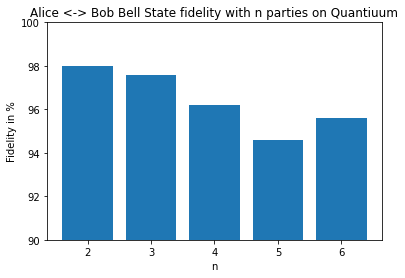


As we can see, there is definitely some noise, and fidelities drop under 95%.
While this might not seem like much, remember that our circuit is extremely small.
This meaning that for larger examples which you can find in other notebooks this effect will be more pronounced.

In the data we also see that (contrary to expectations) $n=5$ has worse fidelity than $n=6$. 
